# Query Log Analysis

The goal of this notebook is to serve as a way to quickly analyze a query log, based on the following aspects:

- Query-level
- Topic-level
- Session-level
- Term-level
- Entity-level

Our main focus is on understanding how people search, in order to improve entity-oriented search, thus we will tackle these aspects always around the entities.

# Datasets

While we take advantage of the Wikipedia query log for this analysis, we use an intermediate structure, so that you can convert your own query log into our format and analyze it. We begin by applying the analysis to the webis-smc-12 dataset, only then adapting the notebook for the Wikipedia query log.

In [1]:
import os
import codecs
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import sklearn as sk
from sklearn import naive_bayes

In [103]:
DEFAULT_FIGSIZE = [15, 3]

plt.rc('figure', figsize=DEFAULT_FIGSIZE)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 6)

The loader functions will be responsible for loading query log datasets and converting them into a Pandas DataFrame with the following valid columns (only columns with data are required):

- user_id
- query
- timestamp
- click_rank
- click_title
- click_url
- click_timestamp

## webis-smc-12
The Webis Search Mission Corpus 2012 (Webis-SMC-12) contains 8840 entries for 127 users. Each entry includes user ID, query, timestamp, rank and domain URL for clicked results, a mission ID and a comment. Each user is preceded by a line of dashes in the text file.

In [3]:
def load_webis_smc_12(path):
    """Load webis-smc-12.txt file into the notebook query log analysis format."""
   
    def date_parser(date_str):
        if type(date_str) is float and np.isnan(date_str):
            return np.nan
        else:
            return pd.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            
    def get_sep_row_idx():
        sep_row_idx = []
        
        with open(path, "r") as fp:
            line_number = 0
            for line in fp:
                if line.startswith("---"):
                    sep_row_idx.append(line_number)
                line_number += 1
        
        return sep_row_idx
    
    df = pd.read_csv(
        'data/webis-smc-12.txt',
        sep='\t',
        lineterminator='\n',
        skiprows=get_sep_row_idx(),
        error_bad_lines=False,
        warn_bad_lines=False,
        parse_dates=['TimeStamp'],
        date_parser=date_parser)

    df.drop(columns=['MissionID', 'Comment'], inplace=True)
    
    df.rename(
        columns={
            'UserID': 'user_id',
            'Query': 'query',
            'TimeStamp': 'timestamp',
            'ClickRank': 'click_rank',
            'ClickDomain': 'click_url'
        },
        inplace=True)
    
    df.click_rank = df.click_rank.astype(pd.Int64Dtype())

    return df

## Data loading

Select one of the available dataset loading functions to begin the analysis:

- load_webis_smc_12

In [4]:
qlog = load_webis_smc_12('data/webis-smc-12.txt'); qlog

,user_id,query,timestamp,click_rank,click_url
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org
4,38534,goody,2006-03-20 16:19:46,NaN,NaN
5,38534,goody,2006-03-20 16:19:47,NaN,NaN
...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN


# Query-level analysis

- Number of queries / interactions
- Number of distinct queries
- Distribution of number of queries / interactions per user
- Distribution of queries / interactions over time
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

## Total number of queries and distinct queries

In [5]:
qlevel_stats = pd.DataFrame(
    [qlog.shape[0], len(qlog['query'].unique())],
    columns=['value'],
    index=['num_queries', 'num_distinct_queries'])
qlevel_stats

,value
num_queries,8838
num_distinct_queries,3736


## Distribution of number of queries per user

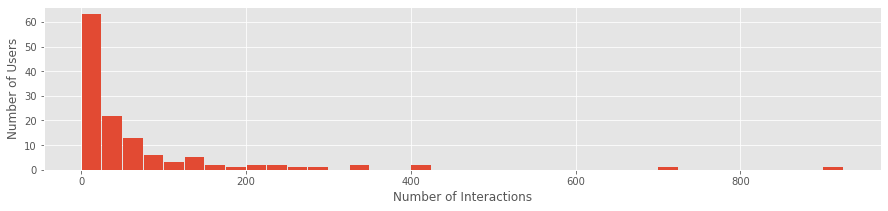

In [6]:
queries_per_user = qlog[['user_id', 'query']] \
    .groupby(['user_id']) \
    .count()

d_min = queries_per_user['query'].min()
d_max = queries_per_user['query'].max()
bin_width = 25

queries_per_user \
    .plot(kind='hist', bins=range(0, d_max+bin_width, bin_width), rwidth=.95, legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

## Distribution of queries over time

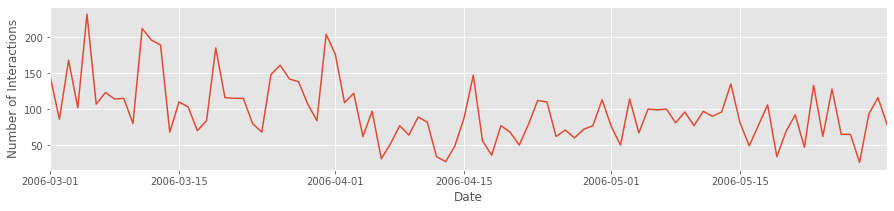

In [7]:
qlog['date'] = qlog['timestamp'].map(lambda t: t.date())

qlog \
    .groupby('date') \
    .size() \
    .plot()
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

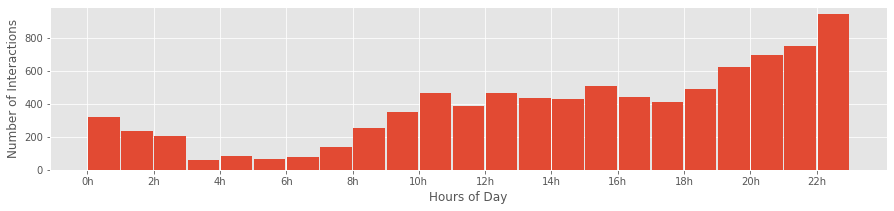

In [8]:
qlog['hour'] = qlog['timestamp'].map(lambda t: t.hour)
qlog['hour'] \
    .plot(kind='hist', bins=23, rwidth=.95)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)])
plt.xlabel('Hours of Day')
plt.ylabel('Number of Interactions')
plt.show()

### Per weekday cycles

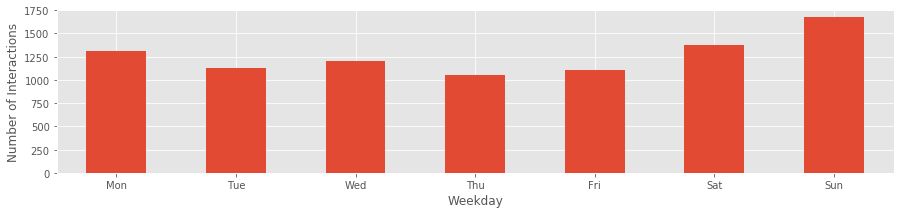

In [9]:
weekdays=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
qlog['weekday'] = qlog['timestamp'].map(lambda t: t.weekday())

qlog \
    .groupby(['weekday']) \
    .size() \
    .plot(kind='bar')

plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel('Weekday')
plt.ylabel('Number of Interactions')
plt.show()

### Per monthly cycles

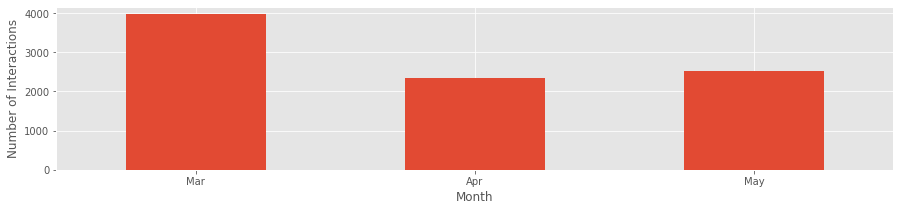

In [10]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
qlog['month'] = qlog['timestamp'].map(lambda t: t.month)

queries_per_month = qlog \
    .groupby(['month']) \
    .size() \

queries_per_month \
    .plot(kind='bar')

plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel('Number of Interactions')
plt.show()

# Topic-level analysis

We train a classifier based on the [BBC dataset](http://mlg.ucd.ie/datasets/bbc.html), with 2225 documents and 5 categories:

- business
- entertainment
- politics
- sport
- tech

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_paths_per_class(bbc_base_dir):
    """Get dictionary of paths per class for BBC dataset."""
    
    bbc = {}
    
    for file in os.listdir(bbc_base_dir):
        class_path = os.path.join(bbc_base_dir, file)
        
        if os.path.isdir(class_path):
            label = file
            bbc[label] = []
            
            for file in os.listdir(class_path):
                doc_path = os.path.join(class_path, file)
                if os.path.isfile(doc_path):
                    bbc[label].append(doc_path)
    
    return bbc


def build_training_set(paths_per_class):
    """Load text documents per class and extract features (TF-IDF per term)."""

    tf_idf = TfidfVectorizer(ngram_range=(1, 2))
    corpus = []
    y = []
    
    for label in paths_per_class.keys():
        for path in paths_per_class[label]:
            try:
                corpus.append(codecs.open(path, 'r', 'utf-8').read())
                y.append(label)
            except:
                print("==> Skipped %s" % (path))
        
    X = tf_idf.fit_transform(corpus)
    return X, y, tf_idf


def train(X, y):
    """
    Train a black box classifier. We chose Naïve Bayes here for returning a probability and having good proven
    performance on this dataset, as shown in: https://towardsdatascience.com/text-classification-in-python-dd95d264c802
    """
    nb = naive_bayes.MultinomialNB()
    nb.fit(X, y)
    return nb


def predict(models, docs, threshold=0.5):
    """
    Predict the correct class according to the probability. If no probability is above the threshold, then the class
    'unknown' is assigned instead.
    """
    predictions = []
    
    for label, model in models.items():
        predictions.append([label] + [p[0] for p in model.predict_proba(features_model.transform(docs))])
    
    cl_prob_per_doc = pd.DataFrame(predictions) \
        .rename({ 0: 'class', 1: 0, 2: 1 }, axis=1) \
        .set_index('class')
    
    cl_prob_per_doc.loc['unknown', :] = cl_prob_per_doc.max().lt(threshold).map(int)
    
    return cl_prob_per_doc.idxmax().tolist()


def select_training_set_for_class(X, y, label):
    """Deal with class imbalance problem by using stratified bootstrapping."""
    cl_idx = {}
    unique_y = np.unique(y)
    
    for u_cl in unique_y:
        if not u_cl in cl_idx:
            cl_idx[u_cl] = []
        cl_idx[u_cl].extend(idx for idx, cl in enumerate(y) if cl == u_cl)
   
    idx = cl_idx[label]
    n_samples = int(np.ceil( len(idx) / (len(unique_y) - 1) ))
    
    for cl in unique_y:
        idx.extend(np.random.choice(cl_idx[cl], n_samples, replace=True))
    
    return idx

In [12]:
paths_per_class = get_paths_per_class('data/bbc')
X, y, features_model = build_training_set(paths_per_class)

models = {}
for label in paths_per_class.keys():
    train_idx = select_training_set_for_class(X, y, label)
    models[label] = train(X[train_idx, :], [y[i] if y[i] == label else 'unknown' for i in train_idx])

==> Skipped data/bbc/sport/199.txt


It seems to work on the following two test queries:

In [13]:
docs = ["government law", "soccer goal", "finance department", "computer science", "grammy award"]
predict(models, docs)

['politics', 'sport', 'business', 'tech', 'entertainment']

Let's also inspect some random rows to see if it makes sense.

In [14]:
qlog['category'] = predict(models, qlog['query']); qlog

,user_id,query,timestamp,click_rank,click_url,date,hour,weekday,month,category
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,23,2,3,politics
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,23,2,3,politics
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics
4,38534,goody,2006-03-20 16:19:46,NaN,NaN,2006-03-20,16,0,3,business
5,38534,goody,2006-03-20 16:19:47,NaN,NaN,2006-03-20,16,0,3,business
...,...,...,...,...,...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN,2006-05-29,15,0,5,business
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN,2006-05-29,15,0,5,business
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,15,0,5,business


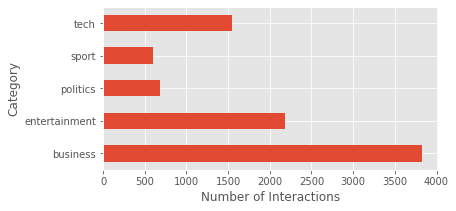

In [15]:
plt.rc('figure', figsize=[6, 3])

qlog[['query', 'category']] \
    .groupby('category') \
    .count() \
    .plot(kind='barh', legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Category')
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

In [16]:
qlog.iloc[np.random.choice(len(qlog), 10)]

,user_id,query,timestamp,click_rank,click_url,date,hour,weekday,month,category
3759,2274372,kenny rogers lyric i cant unlove you,2006-03-26 13:38:40,1,http://www.sing365.com,2006-03-26,13,6,3,entertainment
7245,8818991,jeffersons vice prseident,2006-03-12 13:59:06,3,http://vice-president-of-the-united-states.fae.sk,2006-03-12,13,6,3,business
362,707848,rilo kiley lyrics,2006-04-03 20:29:56,1,http://www.sing365.com,2006-04-03,20,0,4,entertainment
1137,1379196,rough creek lodge,2006-03-06 13:54:55,6,http://www.austinchronicle.com,2006-03-06,13,0,3,sport
4172,2828008,macaroni grill restaurant's penne rustica recipe,2006-03-25 20:33:19,2,http://www.masterstech-home.com,2006-03-25,20,5,3,business
3346,2161465,something for the weekend,2006-03-02 20:09:50,NaN,NaN,2006-03-02,20,3,3,entertainment
1607,1379196,faberware pans,2006-05-14 22:56:06,2,http://www.amazon.com,2006-05-14,22,6,5,business
2368,1936169,gay farm lovin,2006-03-04 00:50:40,20,http://blogs.evergreen.edu,2006-03-04,0,5,3,business
6199,6287652,designer dogs for sale,2006-03-12 21:58:50,1,http://www.puppydogweb.com,2006-03-12,21,6,3,entertainment
3529,2161465,marginal revenue product,2006-05-02 23:23:13,1,http://www.oswego.edu,2006-05-02,23,1,5,business


Some queries were wrongly categorized, since the training set doesn't cover all categories and the classifier we used never returns a probability under 0.5 for all of the labels. This means it's unable to use the unknown category.

Another approach is to instead use an unsupervised algorithm. Classical topic models like LDA would be adequate, if it weren't for the short length of the queries. There is, however, the [biterm topic model](https://dl.acm.org/citation.cfm?id=2488514), which is more adequate for shorter text. Another, even better, approach could be the [relational biterm topic model](https://academic.oup.com/comjnl/article-abstract/62/3/359/5005494?redirectedFrom=fulltext), but since we didn't find any implementation and don't want to implement it ourselves, we will experiment with the biterm topic model.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM

vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(qlog['query']).toarray()

vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)

**Note:** The following code will take a while to run. It's a lot slower than training and predicting with Naïve Bayes. We cache the model, so that we can rerun the whole notebook. Delete `output/cache` to retrain with the same data, otherwise it's fine to leave the cache.

In [49]:
from joblib import Memory
memory = Memory('output/cache', verbose=0)

num_topics = 20

def biterm_train(num_topics, vocabulary, biterms, iterations=100):
    btm = oBTM(num_topics=num_topics, V=vocab)
    topics = btm.fit_transform(biterms, iterations=iterations)
    return btm, topics
biterm_train = memory.cache(biterm_train)

btm, topics = biterm_train(num_topics, vocab, biterms, iterations=100)

100%|██████████| 100/100 [09:49<00:00,  5.79s/it]
/home/jldevezas/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


We now take the topic distribution over the vocabulary and keep the top five terms, with highest probability, per topic.

In [101]:
topic_names = []
for i in range(20):
    idx = btm.phi_wz[:, i].argsort()[::-1][:5]
    topic_names.append(' '.join(vocab[i] for i in idx))

qlog['topic'] = [topic_names[topics[i].argmax()] for i in range(len(qlog))]; qlog

,user_id,query,timestamp,click_rank,click_url,date,hour,weekday,month,category,topic,session_id,person,organization,place
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,23,2,3,politics,department florida master rent conference,2,None,[police],[maryland]
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,23,2,3,politics,st louis bank county credit,2,None,None,None
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,department florida master rent conference,2,None,"[police, aberdeen]","[maryland, aberdeen]"
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,department florida master rent conference,2,None,"[police, aberdeen]","[maryland, aberdeen]"
4,38534,goody,2006-03-20 16:19:46,NaN,NaN,2006-03-20,16,0,3,business,beach club wailea polo cards,3,None,None,None
5,38534,goody,2006-03-20 16:19:47,NaN,NaN,2006-03-20,16,0,3,business,beach club wailea polo cards,3,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN,2006-05-29,15,0,5,business,st louis bank county credit,2547,None,None,None
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN,2006-05-29,15,0,5,business,st louis bank county credit,2547,None,None,None
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,15,0,5,business,st louis bank county credit,2547,None,None,None


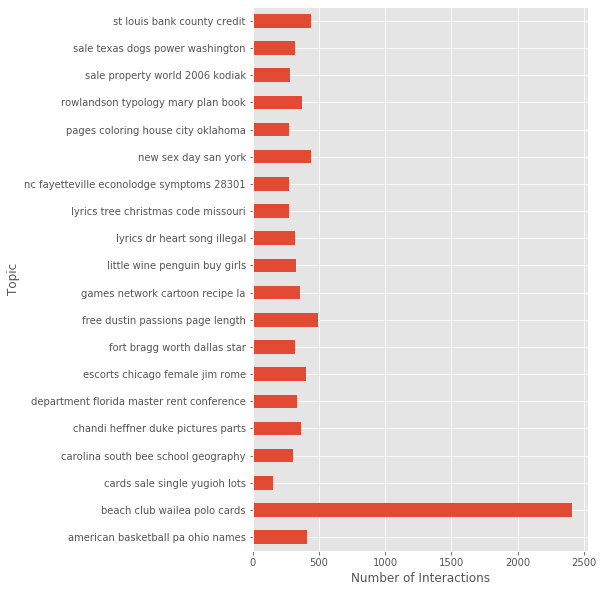

In [104]:
plt.rc('figure', figsize=[6, 10])

qlog[['query', 'topic']] \
    .groupby('topic') \
    .count() \
    .plot(kind='barh', legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Topic')
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

So far, we have identified news-based categories for queries, as well as topics as a distribution of words from within the query log. We visualized:

- Distribution of query categories
- Distribution of query topics

Next, we will analyze:

- Distribution of query categories over time:
  - Per 24h cycles
  - Per weekday cycles
  - Per monthly cycles


- Distribution of query topics over time:
  - Per 24h cycles
  - Per weekday cycles
  - Per monthly cycles

## Distribution of query categories over time

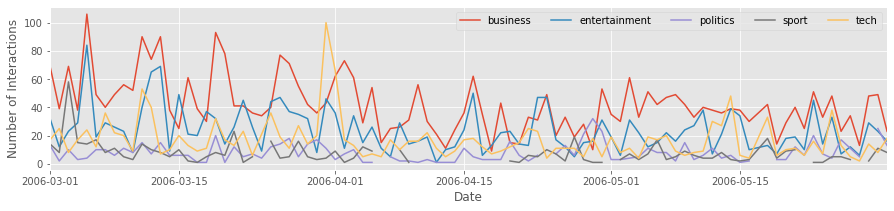

In [224]:
categories_over_time = qlog[['query', 'category', 'date']] \
    .groupby(['category', 'date']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('date') \
    .drop('level_0', axis=1) \
    .fillna(0)

categories_over_time.plot()
plt.legend(loc='upper right', ncol=5)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

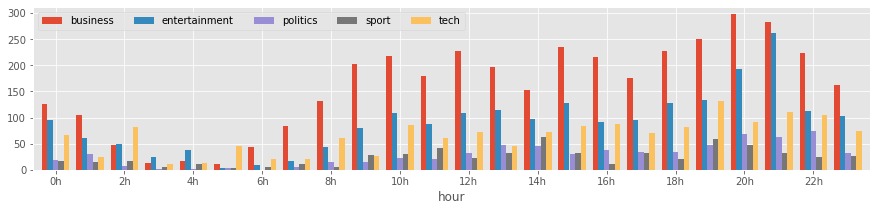

In [107]:
qlog[['query', 'category', 'hour']] \
    .groupby(['category', 'hour']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('hour') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=6)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.show()

### Per weekday cycles

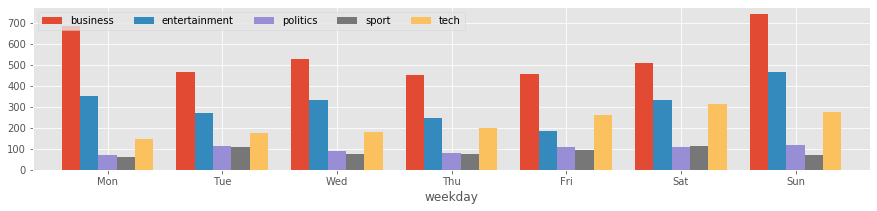

In [108]:
qlog[['query', 'category', 'weekday']] \
    .groupby(['category', 'weekday']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('weekday') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=6)
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.show()

### Per monthly cycles

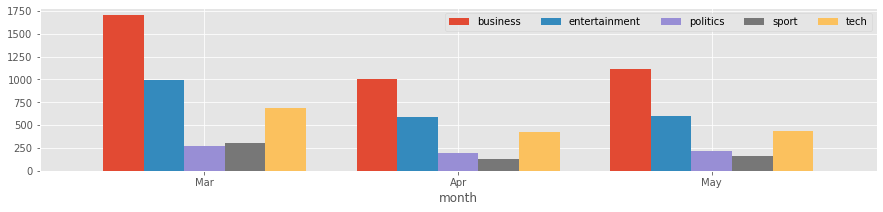

In [109]:
qlog[['query', 'category', 'month']] \
    .groupby(['category', 'month']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('month') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper right', ncol=6)
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.show()

## Distribution of query topics over time

In [ ]:
top_topics = qlog[['query', 'topic']] \
    .groupby('topic') \
    .count() \
    .sort_values(by="query", ascending=False) \
    .rename({'query': 'count'}, axis=1) \
    .head(4)

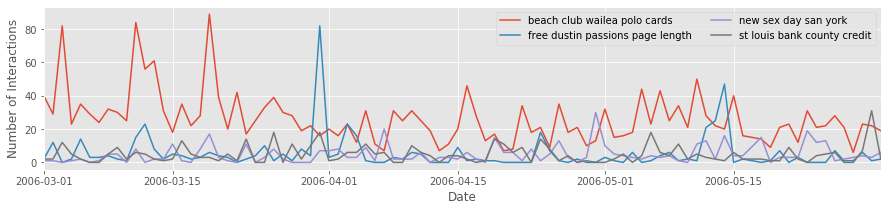

In [188]:
topics_over_time = qlog[['query', 'topic', 'date']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'date']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('date') \
    .drop('level_0', axis=1) \
    .fillna(0)

topics_over_time.plot()
plt.legend(loc='upper right', ncol=2)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

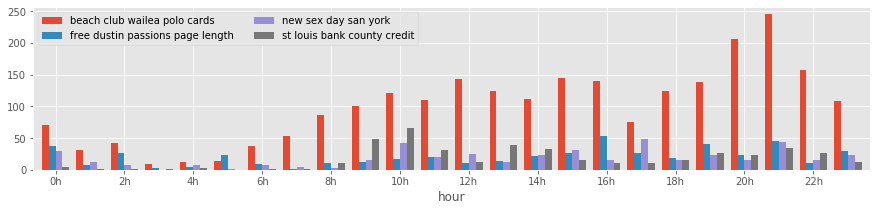

In [214]:
qlog[['topic', 'hour']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'hour']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('hour') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=2)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.show()

### Per weekday cycles

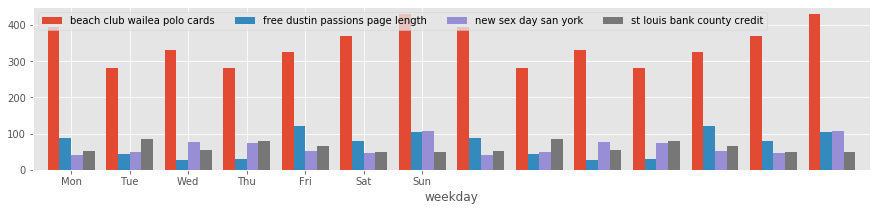

In [223]:
qlog[['query', 'topic', 'weekday']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'weekday']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('weekday') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=4)
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.show()

### Per monthly cycles

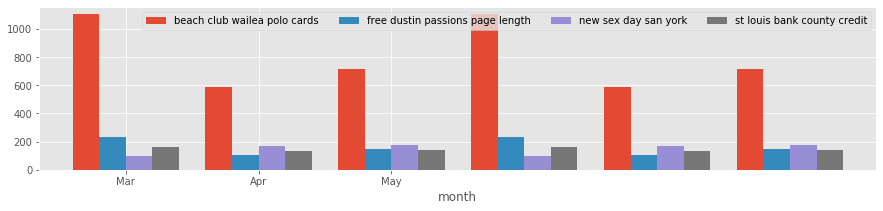

In [222]:
qlog[['query', 'topic', 'month']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'month']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('month') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper right', ncol=4)
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.show()

# Session-level analysis

- Number of queries / interactions per session
- Number of distinct queries per session
- Session duration distribution
- Distribution of number of clicks per session
- Average clicked rank per session duration


- Average session duration:
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

**Note:** Don't run the following code block if there is already a "session_id" column.

In [25]:
from datetime import timedelta

def detect_sessions(qlog, mins=30):
    qlog.drop('session_id', axis=1, errors='ignore', inplace=True)
    new_sessions = pd.Series([], dtype='int64')
    for _, user_qlog in qlog.sort_values(by=['user_id', 'timestamp']).groupby('user_id'):
        user_new_sessions = user_qlog.timestamp.gt(user_qlog.timestamp.shift() + timedelta(minutes=mins))
        user_new_sessions.iloc[0] = True
        new_sessions = new_sessions.append(user_new_sessions)
    return pd.concat([
        qlog.sort_values(by=['user_id', 'timestamp']),
        pd.DataFrame({ 'session_id': new_sessions.cumsum() + 1 })
    ], axis=1, sort=False)

qlog = detect_sessions(qlog); qlog

,user_id,query,timestamp,click_rank,click_url,date,hour,weekday,month,category,topic,session_id
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,23,2,3,politics,county family jose san white,2
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,23,2,3,politics,celebs county hot oops testing,2
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,county family jose san white,2
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,county family jose san white,2
4,38534,goody,2006-03-20 16:19:46,NaN,NaN,2006-03-20,16,0,3,business,bank credit free louis st,3
5,38534,goody,2006-03-20 16:19:47,NaN,NaN,2006-03-20,16,0,3,business,bank credit free louis st,3
...,...,...,...,...,...,...,...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN,2006-05-29,15,0,5,business,dustin jim page passions rome,2547
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN,2006-05-29,15,0,5,business,dustin jim page passions rome,2547
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,15,0,5,business,dustin jim page passions rome,2547


## Number of interactions per session

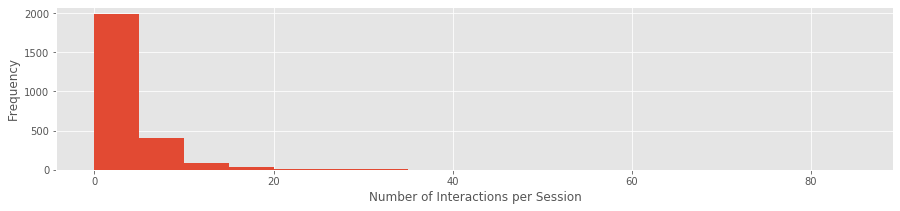

In [26]:
queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .count()

d_min = queries_per_session['query'].min()
d_max = queries_per_session['query'].max()
bin_width = 5

queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Interactions per Session")
plt.ylabel("Frequency")
plt.show()

## Number of distinct queries per session

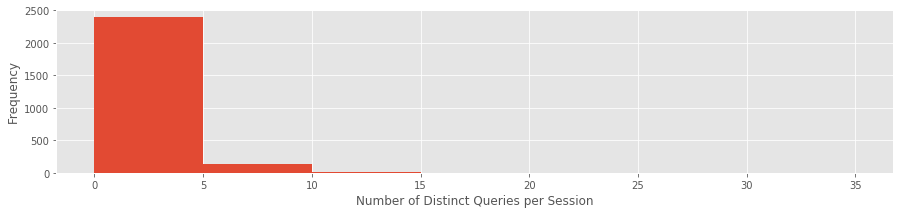

In [27]:
distinct_queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .nunique()

distinct_queries_per_session['session_id'] = distinct_queries_per_session.index
distinct_queries_per_session.drop('session_id', axis=1, inplace=True)
distinct_queries_per_session = distinct_queries_per_session.reset_index().drop('session_id', axis=1)

d_min = distinct_queries_per_session['query'].min()
d_max = distinct_queries_per_session['query'].max()
bin_width = 5

distinct_queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Distinct Queries per Session")
plt.ylabel("Frequency")
plt.show()

## Session duration distribution

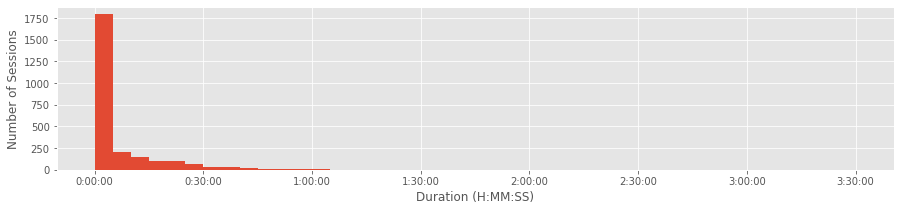

In [28]:
from matplotlib.ticker import FuncFormatter

session_durations = qlog[['session_id', 'timestamp']] \
    .groupby('session_id') \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1)

d_min = session_durations['duration'].min()
d_max = session_durations['duration'].max()
bin_width = 5/60

ax = session_durations \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: timedelta(seconds=x * 3600)))
plt.xlabel("Duration (H:MM:SS)")
plt.ylabel("Number of Sessions")
plt.show()

## Distribution of number of clicks per session

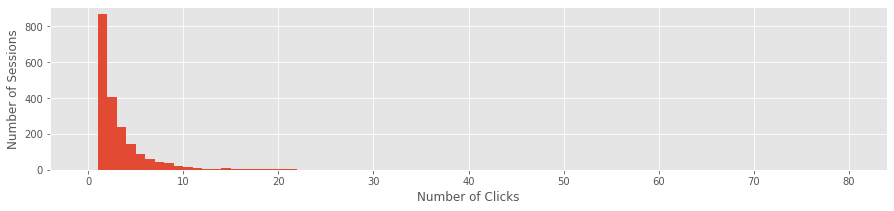

In [29]:
session_clicks = qlog[~qlog['click_rank'].isnull()][['session_id', 'click_rank']] \
    .groupby('session_id') \
    .count() \
    .reset_index() \
    .drop('session_id', axis=1) \
    .rename({ 'click_rank': 'click_count' }, axis=1)

d_min = session_clicks['click_count'].min()
d_max = session_clicks['click_count'].max()
bin_width = 1

session_clicks \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), logy=False, legend=False)
plt.xlabel("Number of Clicks")
plt.ylabel("Number of Sessions")
plt.show()

## Average session duration

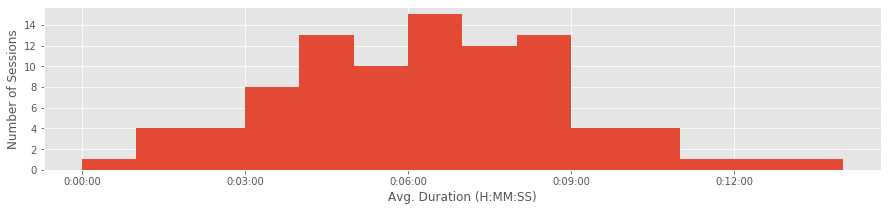

In [30]:
from matplotlib.ticker import FuncFormatter

session_durations_per_day = qlog[['session_id', 'date', 'timestamp']] \
    .groupby(['session_id', 'date']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('date') \
    .mean()

d_max = session_durations_per_day['duration'].max()
bin_width = 1/60

ax = session_durations_per_day \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=hour * 3600)))
plt.xlabel("Avg. Duration (H:MM:SS)")
plt.ylabel("Number of Sessions")
plt.show()

### Per 24h cycles

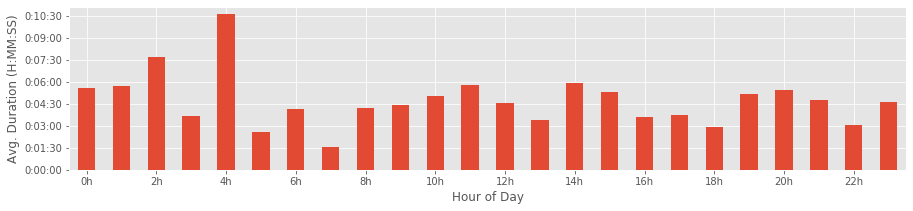

In [31]:
from matplotlib.ticker import FuncFormatter

session_durations_per_hour_of_day = qlog[['session_id', 'hour', 'timestamp']] \
    .groupby(['session_id', 'hour']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('hour') \
    .mean()

ax = session_durations_per_hour_of_day \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.xlabel("Hour of Day")
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

### Per weekday cycles

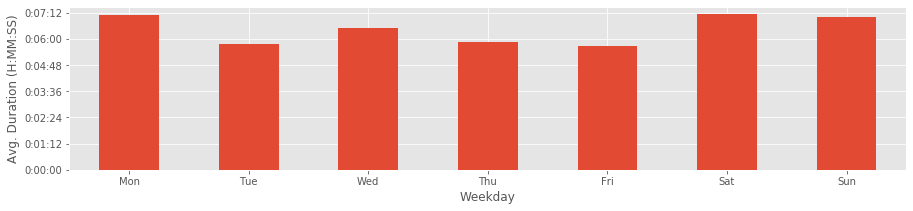

In [32]:
from matplotlib.ticker import FuncFormatter

session_durations_per_weekday = qlog[['session_id', 'weekday', 'timestamp']] \
    .groupby(['session_id', 'weekday']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('weekday') \
    .mean()

ax = session_durations_per_weekday \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel("Weekday")
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

### Per monthly cycles

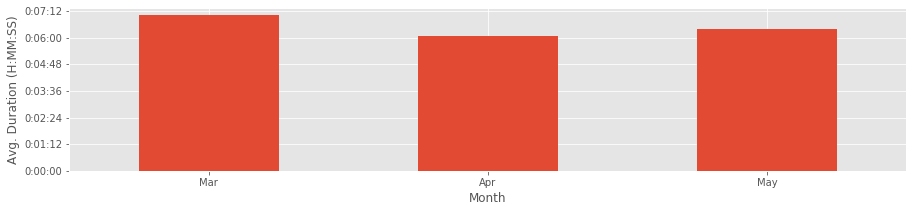

In [33]:
from matplotlib.ticker import FuncFormatter

session_durations_per_month = qlog[['session_id', 'month', 'timestamp']] \
    .groupby(['session_id', 'month']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('month') \
    .mean()

ax = session_durations_per_month \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

## Average clicked rank per session duration

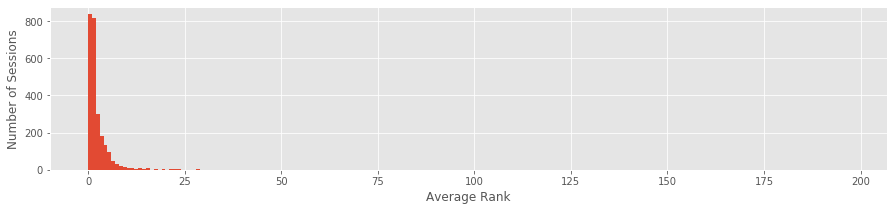

In [34]:
session_avg_rank = qlog[['session_id', 'click_rank']] \
    .fillna(0) \
    .groupby('session_id') \
    .mean() \
    .reset_index() \
    .drop('session_id', axis=1) \
    .rename({ 'click_rank': 'avg_rank' }, axis=1)

d_min = session_avg_rank['avg_rank'].min()
d_max = int(np.ceil(session_avg_rank['avg_rank'].max()))
bin_width = 1

session_avg_rank \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), logy=False, legend=False)
plt.xlabel("Average Rank")
plt.ylabel("Number of Sessions")
plt.show()

# Term-level analysis

The term-level analysis is concerned with the characteristics of the words that form the queries. Our analysis includes:

- Query length
  - Number of characters
  - Number of terms
- Term distribution
- Term popularity over time for top terms

In [35]:
#qlog['length'] = 'query_chars'
#qlog['num_words'] = 'query_words'

# Entity-level analysis

We identified entities taking advantage of the `AhoCorasickEntityExtractor` class available in [Army ANT](https://github.com/feup-infolab/army-ant). We copied [aho_corasick_entity_extractor.py](../../edit/query_log_analysis/aho_corasick_entity_extractor.py) to the notebook workspace and edited it to be usable as a standalone dependency. We then used the English DBpedia `rdfs:label` for entities with the class `dbo:Person`, `dbo:Organisation` and `dbp:Place` as the dictionary.

Our analysis includes:

- Entity distribution per class
- Entity distribution over time for top entities

It also includes higher order analyses, further described in each of the following sections:

- Entity-query-level analysis
- Entity-topic-level analysis
- Entity-session-level analysis
- Entity-term-level analysis
- Entity-entity level analysis

In [36]:
from aho_corasick_entity_extractor import AhoCorasickEntityExtractor
ac = {
    'person': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_person.txt'),
    'organization': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_organization.txt'),
    'place': AhoCorasickEntityExtractor(list_path='data/en_dbpedia_place.txt')
}

In [37]:
from collections import OrderedDict
from functools import reduce

for d_class in ac.keys():
    qlog[d_class] = None

    for i in range(len(qlog)):
        query = qlog.loc[i, 'query']
        entities = ac[d_class].extract(query)
        
        for entity in entities:
            if qlog.loc[i, d_class] is None:
                qlog.at[i, d_class] = [entity]
            else:
                qlog.at[i, d_class].append(entity)

qlog

,user_id,query,timestamp,click_rank,click_url,date,hour,weekday,month,category,topic,session_id,person,organization,place
0,38534,maryland state police,2006-03-01 23:48:15,1,http://www.mdsp.org,2006-03-01,23,2,3,politics,county family jose san white,2,None,[police],[maryland]
1,38534,harford county sheriff,2006-03-01 23:55:13,1,http://www.harfordsheriff.org,2006-03-01,23,2,3,politics,celebs county hot oops testing,2,None,None,None
2,38534,aberdeen police department in maryland,2006-03-01 23:59:35,2,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,county family jose san white,2,None,"[police, aberdeen]","[maryland, aberdeen]"
3,38534,aberdeen police department in maryland,2006-03-01 23:59:35,1,http://www.aberdeen-md.org,2006-03-01,23,2,3,politics,county family jose san white,2,None,"[police, aberdeen]","[maryland, aberdeen]"
4,38534,goody,2006-03-20 16:19:46,NaN,NaN,2006-03-20,16,0,3,business,bank credit free louis st,3,None,None,None
5,38534,goody,2006-03-20 16:19:47,NaN,NaN,2006-03-20,16,0,3,business,bank credit free louis st,3,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8832,24797984,fw signs from god,2006-05-29 15:42:52,NaN,NaN,2006-05-29,15,0,5,business,dustin jim page passions rome,2547,None,None,None
8833,24797984,fw signs from god,2006-05-29 15:43:41,NaN,NaN,2006-05-29,15,0,5,business,dustin jim page passions rome,2547,None,None,None
8834,24797984,fw signs from god,2006-05-29 15:43:49,NaN,NaN,2006-05-29,15,0,5,business,dustin jim page passions rome,2547,None,None,None


In [38]:
import itertools

qlog_entities = pd.DataFrame(columns=['entity', 'class', 'count'])

for d_class in ac.keys():
    entity_count = pd.DataFrame({
            'entity': list(itertools.chain(*filter(lambda d: d is not None, qlog[d_class]))),
            'class': d_class
        }) \
        .groupby(['entity', 'class']) \
        .size() \
        .reset_index() \
        .rename({0: 'count'}, axis='columns')
    
    qlog_entities = qlog_entities.append(entity_count)

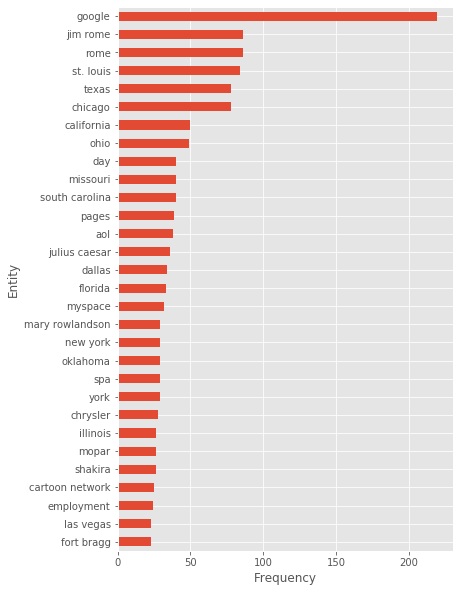

In [39]:
plt.rc('figure', figsize=[6, 10])

qlog_entities[['entity', 'count']] \
    .groupby('entity') \
    .sum() \
    .reset_index() \
    .sort_values(by='count', ascending=False) \
    .head(30) \
    .plot(kind='barh', x='entity', y='count', legend=False)

plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

In [40]:
def plot_entities_by_class(qlog_entities, d_class):
    plt.rc('figure', figsize=[6, 10])

    qlog_entities[qlog_entities['class'] == d_class] \
        .sort_values(by='count', ascending=False) \
        .head(30) \
        .plot(kind='barh', x='entity', y='count', legend=False)

    plt.xlabel('Frequency')
    plt.ylabel(d_class.title())
    plt.gca().invert_yaxis()
    plt.show()

    plt.rc('figure', figsize=DEFAULT_FIGSIZE)

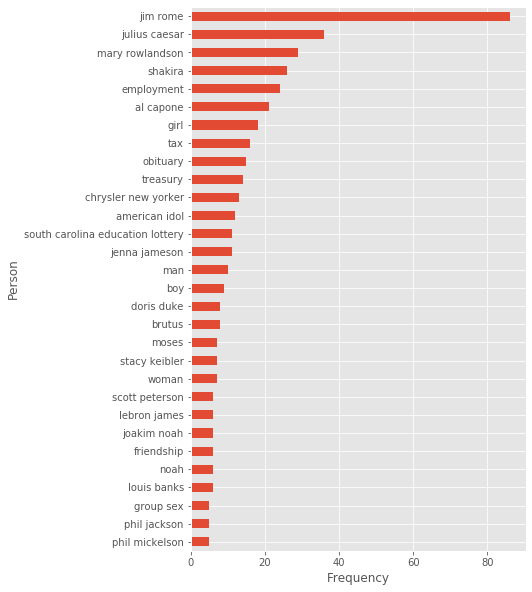

In [41]:
plot_entities_by_class(qlog_entities, 'person')

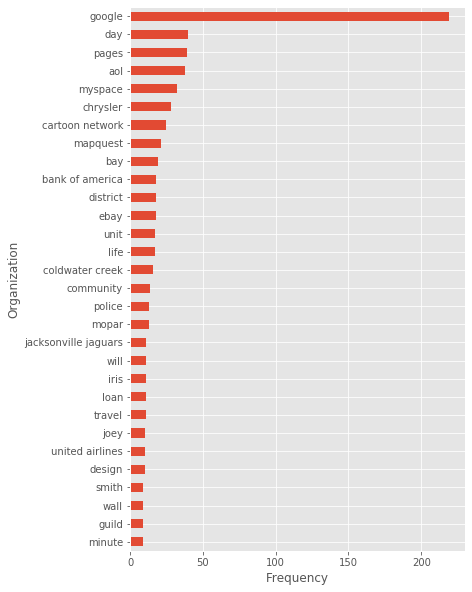

In [42]:
plot_entities_by_class(qlog_entities, 'organization')

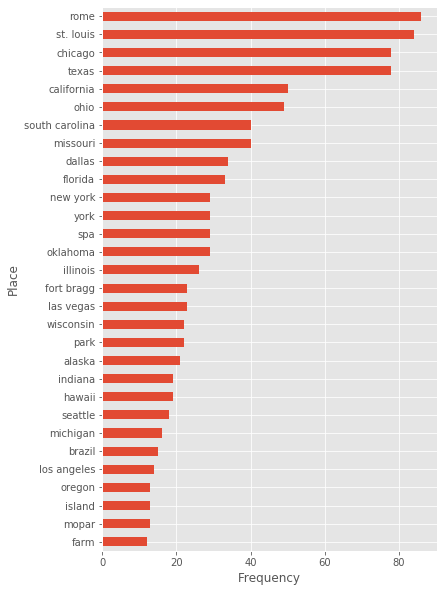

In [43]:
plot_entities_by_class(qlog_entities, 'place')

## Entity-query-level analysis

## Entity-topic-level analysis

## Entity-session-level analysis

- Grafo de entidades numa sessão
  - Distâncias

## Entity-term-level analysis

## Entity-entity-level analysis